In [3]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.model_selection import train_test_split # Split de dataset et optimisation des hyperparamètres

from sklearn.metrics import confusion_matrix # Métriques pour la mesure de performances
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from keras.layers import Dense

import joblib
import seaborn as sns



2023-08-09 11:04:59.310062: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 11:04:59.312318: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 11:04:59.351304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 11:04:59.352074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 11:05:00.163663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:

column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

df = pd.DataFrame(columns = column_names)

# Définissons la liste avec les genres :
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Création d'un dictionnaire avec les genres vide :
audio_files = {}


for g in genres:
  audio_files[g] = []

# Remplissage du dictionnaire en important les fichiers audio avec Librosa :
for g in genres:
  for audio in os.listdir(f'./dataset/genres_original/{g}'):
    audio_files[g].append(librosa.load(f'./dataset/genres_original/{g}/{audio}')[0])

In [5]:
def audio_pipeline(audio):
  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))


  return features

# Définissons les noms des colonnes

column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

# Création d'un dataframe vide

df = pd.DataFrame(columns = column_names)

# On itère sur les audios pour remplir le dataframe

i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1
df.to_csv('music3.csv', index = False)


In [6]:
df = pd.read_csv('music.csv')
# features = pd.read_csv('music.xls')
features = df
# One-hot encode
labels = pd.get_dummies(features['label'])
# enleve les labels des features
features = features.drop('label', axis = 1)
# sauvegarde la liste des features
feature_list = list(features.columns)
# conversion en numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state = 0)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# scaling
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

joblib.dump(sc, "scaler.pkl")

Training Features Shape: (711, 23)
Training Labels Shape: (711, 10)
Testing Features Shape: (238, 23)
Testing Labels Shape: (238, 10)


['scaler.pkl']

In [91]:
# création du modèle
model = Sequential()
model.add(Dense(161, input_dim=23, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit le modèle
history = model.fit(train_features, train_labels, epochs=200, batch_size=20, verbose=0, validation_data=(test_features, test_labels))

# prédiction
predictions = model.predict(test_features)

# pred_classes = np.argmax(predictions, axis=1) 
# confusion_mtx = confusion_matrix(labels, pred_classes)

# evaluation du modèle
_, accuracy = model.evaluate(test_features, test_labels, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))
# model.save("neuralNetwork.hdf5")


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 161)               3864      
                                                                 
 dense_119 (Dense)           (None, 10)                1620      
                                                                 
Total params: 5484 (21.42 KB)
Trainable params: 5484 (21.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


8/8 [==============================] - 0s 777us/step
Accuracy: 65.55


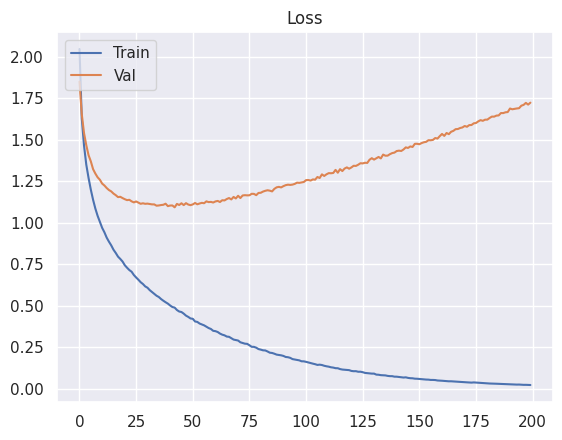

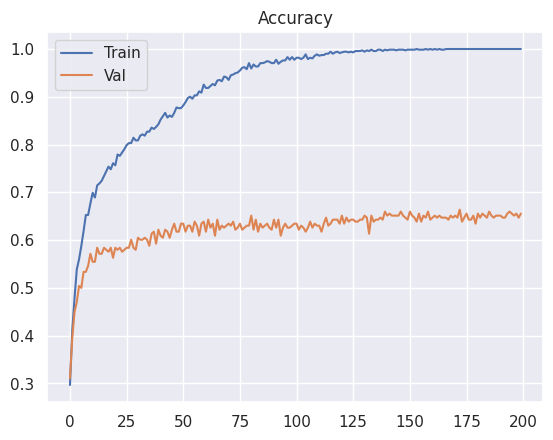

In [92]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

8/8 [==============================] - 0s 752us/step


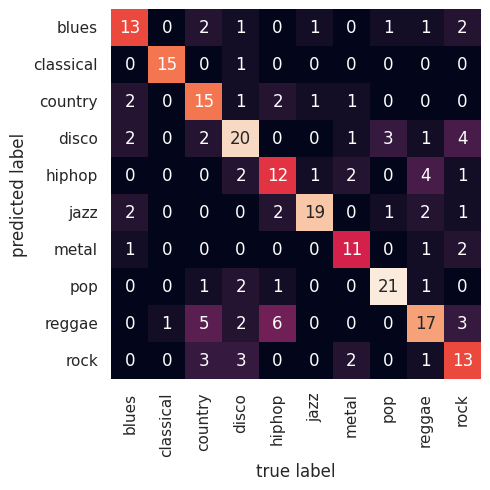

In [93]:

from matplotlib import pyplot as plt 

sns.set()
predictions = model.predict(test_features)
mat = confusion_matrix(np.argmax(test_labels, 1), np.argmax(predictions, 1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

dekfzj

In [13]:

# Load and preprocess the audio file
def preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=None)
    
    # Apply the same feature extraction and scaling as you did during training
    features = audio_pipeline(audio)
    scaled_features = sc.transform([features]) 
    
    return scaled_features

# Make predictions on the preprocessed audio
def predict_top_genres(file_path, top_n=3):
    scaled_features = preprocess_audio(file_path)
    predicted_probabilities = model.predict(scaled_features)
    top_n_indices = np.argsort(predicted_probabilities[0])[::-1][:top_n]
    top_n_genres = [genres[idx] for idx in top_n_indices]
    prediction_percentages = [predicted_probabilities[0][idx] * 100 for idx in top_n_indices]
    return top_n_genres, prediction_percentages

# Provide the path to the audio file you want to classify
audio_file_path = './dataset/to_check/sound/hiphop/hiphop.00000.wav'
top_genres, prediction_percentages = predict_top_genres(audio_file_path)

for i, genre in enumerate(top_genres):
    print( i+1, genre,'{:.2f}%'.format(prediction_percentages[i]))

1/1 [==============================] - 0s 26ms/step
1 disco 64.50%
2 hiphop 18.85%
3 rock 5.90%
